In [1]:
# import packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import idx2numpy
import os
from PIL import Image

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [2]:
# Define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Prepare data
# Load the training set
X_train = idx2numpy.convert_from_file('../datasets/MNIST/raw/train-images-idx3-ubyte')
y_train = idx2numpy.convert_from_file('../datasets/MNIST/raw/train-labels-idx1-ubyte')

# Load the test set
X_test = idx2numpy.convert_from_file('../datasets/MNIST/raw/t10k-images-idx3-ubyte')
y_test = idx2numpy.convert_from_file('../datasets/MNIST/raw/t10k-labels-idx1-ubyte')

In [4]:
# Define the rotation function
def img_rotate(img, deg=90):
    img = Image.fromarray(img).rotate(deg, expand=True)
    return np.array(img)

In [5]:
# Expand X_train and y_train
X_train_all = []
y_train_all = []

for (x, y) in zip(X_train, y_train):
    X_train_all.append(x)
    X_train_all.append(img_rotate(x, 90))
    X_train_all.append(img_rotate(x, 180))
    X_train_all.append(img_rotate(x, 270))

    for i in range(4):
        y_train_all.append((y, i))

        
X_train_all = torch.Tensor(np.reshape(X_train_all, (240000, 1, 28, 28)))
y_train_all = torch.Tensor(np.array(y_train_all, dtype=np.int64))

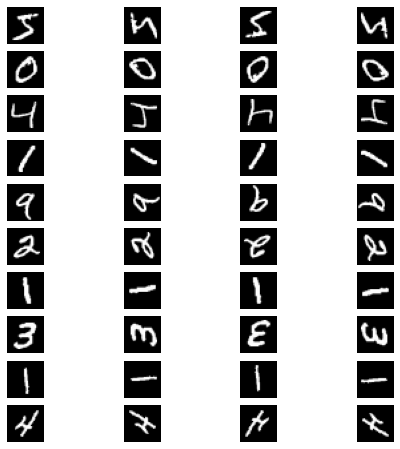

tensor([[5., 0.],
        [5., 1.],
        [5., 2.],
        [5., 3.],
        [0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [4., 0.],
        [4., 1.],
        [4., 2.],
        [4., 3.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [9., 0.],
        [9., 1.],
        [9., 2.],
        [9., 3.],
        [2., 0.],
        [2., 1.],
        [2., 2.],
        [2., 3.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [3., 0.],
        [3., 1.],
        [3., 2.],
        [3., 3.],
        [1., 0.],
        [1., 1.],
        [1., 2.],
        [1., 3.],
        [4., 0.],
        [4., 1.],
        [4., 2.],
        [4., 3.]])


In [6]:
# Display 40 images from X_train
fig, axs = plt.subplots(10, 4, figsize=(8, 8))
for i in range(10):
    for j in range(4):
        axs[i, j].imshow(X_train_all[i*4+j, 0, :], cmap="gray")
        axs[i, j].axis("off")
plt.show()
print(y_train_all[:40])

In [7]:
class JointCNN(nn.Module):
    def __init__(self):
        super(JointCNN, self).__init__()
        # Shared layers - theta E
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Branch 1 - theta M
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

        # Branch 2 - theta S
        self.fc3 = nn.Linear(64 * 7 * 7, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x1 = torch.relu(self.bn1(self.fc1(x)))
        x1 = self.fc2(x1)
        x1 = F.log_softmax(x1, dim=1)
        x2 = torch.relu(self.bn2(self.fc3(x)))
        x2 = self.fc4(x2)
        x2 = F.log_softmax(x2, dim=1)
        return x1, x2
    

# Define my dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
# Set up the data loaders
train_loader = torch.utils.data.DataLoader(MyDataset(X_train_all, y_train_all), batch_size=64, shuffle=True)

# Define the loss functions
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()


# Initialize the model and define optimizer
model = JointCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        labels_1 = labels[:,0].to(torch.int64)
        labels_2 = labels[:,1].to(torch.int64)
        images, labels_1, labels_2 = images.to(device), labels_1.to(device), labels_2.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        out1, out2 = model(images)

        # Compute the loss
        loss1 = criterion1(out1, labels_1)
        loss2 = criterion2(out2, labels_2)
        loss = loss1 + loss2

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [100/3750], Loss: 0.5902
Epoch [1/10], Step [200/3750], Loss: 0.2987
Epoch [1/10], Step [300/3750], Loss: 0.2613
Epoch [1/10], Step [400/3750], Loss: 0.2541
Epoch [1/10], Step [500/3750], Loss: 0.2429
Epoch [1/10], Step [600/3750], Loss: 0.1489
Epoch [1/10], Step [700/3750], Loss: 0.2029
Epoch [1/10], Step [800/3750], Loss: 0.0828
Epoch [1/10], Step [900/3750], Loss: 0.1246
Epoch [1/10], Step [1000/3750], Loss: 0.0926
Epoch [1/10], Step [1100/3750], Loss: 0.1358
Epoch [1/10], Step [1200/3750], Loss: 0.1361
Epoch [1/10], Step [1300/3750], Loss: 0.1818
Epoch [1/10], Step [1400/3750], Loss: 0.1276
Epoch [1/10], Step [1500/3750], Loss: 0.2403
Epoch [1/10], Step [1600/3750], Loss: 0.0881
Epoch [1/10], Step [1700/3750], Loss: 0.1486
Epoch [1/10], Step [1800/3750], Loss: 0.0982
Epoch [1/10], Step [1900/3750], Loss: 0.1789
Epoch [1/10], Step [2000/3750], Loss: 0.0955
Epoch [1/10], Step [2100/3750], Loss: 0.0959
Epoch [1/10], Step [2200/3750], Loss: 0.0652
Epoch [1/10], Step 

Epoch [5/10], Step [3700/3750], Loss: 0.0607
Epoch [6/10], Step [100/3750], Loss: 0.0039
Epoch [6/10], Step [200/3750], Loss: 0.0138
Epoch [6/10], Step [300/3750], Loss: 0.0113
Epoch [6/10], Step [400/3750], Loss: 0.0116
Epoch [6/10], Step [500/3750], Loss: 0.0131
Epoch [6/10], Step [600/3750], Loss: 0.0018
Epoch [6/10], Step [700/3750], Loss: 0.0280
Epoch [6/10], Step [800/3750], Loss: 0.0083
Epoch [6/10], Step [900/3750], Loss: 0.0179
Epoch [6/10], Step [1000/3750], Loss: 0.0071
Epoch [6/10], Step [1100/3750], Loss: 0.0093
Epoch [6/10], Step [1200/3750], Loss: 0.0088
Epoch [6/10], Step [1300/3750], Loss: 0.0671
Epoch [6/10], Step [1400/3750], Loss: 0.0274
Epoch [6/10], Step [1500/3750], Loss: 0.0419
Epoch [6/10], Step [1600/3750], Loss: 0.0317
Epoch [6/10], Step [1700/3750], Loss: 0.0031
Epoch [6/10], Step [1800/3750], Loss: 0.0073
Epoch [6/10], Step [1900/3750], Loss: 0.0073
Epoch [6/10], Step [2000/3750], Loss: 0.0526
Epoch [6/10], Step [2100/3750], Loss: 0.0127
Epoch [6/10], Step 

Epoch [10/10], Step [3500/3750], Loss: 0.0228
Epoch [10/10], Step [3600/3750], Loss: 0.0018
Epoch [10/10], Step [3700/3750], Loss: 0.0014


In [10]:
# Expand X_test and y_test
X_test_all = []
y_test_all = []

for (x, y) in zip(X_test, y_test):
    X_test_all.append(x)
    X_test_all.append(img_rotate(x, 90))
    X_test_all.append(img_rotate(x, 180))
    X_test_all.append(img_rotate(x, 270))

    for i in range(4):
        y_test_all.append((y, i))

        
X_test_all = torch.Tensor(np.reshape(X_test_all, (40000, 1, 28, 28)))
y_test_all = torch.Tensor(np.array(y_test_all, dtype=np.int64))

In [34]:
test_loader = torch.utils.data.DataLoader(MyDataset(X_test_all, y_test_all), batch_size=1000, shuffle=True)

# Compute the accuracy on the test set
correct1 = 0
correct2 = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        labels_1 = labels[:,0].to(torch.int64)
        labels_2 = labels[:,1].to(torch.int64)
        images, labels_1, labels_2 = images.to(device), labels_1.to(device), labels_2.to(device)

        # Forward pass
        out1, out2 = model(images)

        # Compute the accuracy for branch
        _, predicted = torch.max(out1.data, 1)
        correct1 += (predicted == labels_1).sum().item()
        _, predicted = torch.max(out2.data, 1)
        correct2 += (predicted == labels_2).sum().item()
        total += labels_2.size(0)

print('Accuracy for image classification: %.2f%%' % (100 * correct1 / total))
print('Accuracy for rotation classification: %.2f%%' % (100 * correct2 / total))

Accuracy for image classification: 98.92%
Accuracy for rotation classification: 99.60%


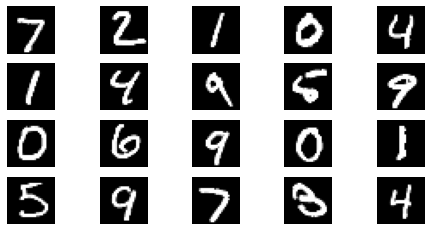

Accuracy: 70.91%


In [24]:
accuracy = []

X_test2 = np.load('../datasets/mnist_c/brightness/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/brightness/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        out1, _ = model(images)
        _, predicted = torch.max(out1.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

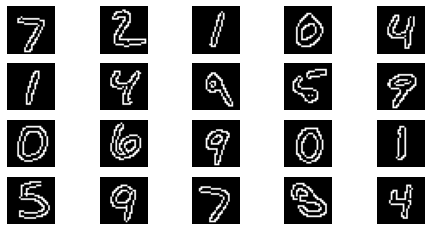

Accuracy: 73.12%


In [25]:
X_test2 = np.load('../datasets/mnist_c/canny_edges/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/canny_edges/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        out1, _ = model(images)
        _, predicted = torch.max(out1.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

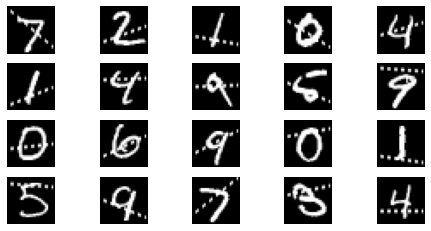

Accuracy: 85.07%


In [26]:
X_test2 = np.load('../datasets/mnist_c/dotted_line/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/dotted_line/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        out1, _ = model(images)
        _, predicted = torch.max(out1.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

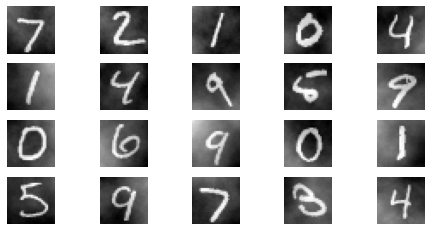

Accuracy: 30.88%


In [27]:
X_test2 = np.load('../datasets/mnist_c/fog/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/fog/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        out1, _ = model(images)
        _, predicted = torch.max(out1.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

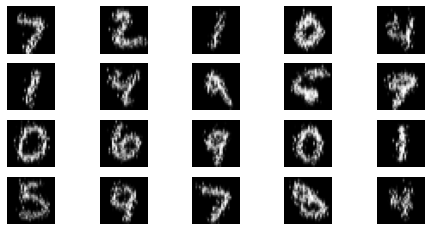

Accuracy: 60.39%


In [28]:
X_test2 = np.load('../datasets/mnist_c/glass_blur/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/glass_blur/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        out1, _ = model(images)
        _, predicted = torch.max(out1.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))

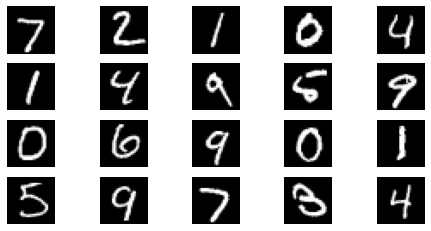

Accuracy: 91.98%


In [33]:
X_test2 = np.load('../datasets/mnist_c/identity/test_images.npy')
X_t2 = torch.from_numpy(np.reshape(X_test2, (10000, 1, 28, 28))).float()
y_test2 = np.load('../datasets/mnist_c/identity/test_labels.npy')
X_t2_loader = torch.utils.data.DataLoader(MyDataset(X_t2, y_test2), batch_size=1000, shuffle=True)

# Display 20 images
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(X_test2[i*5+j], cmap="gray")
        axs[i, j].axis("off")
plt.show()

correct = 0
total = 0
with torch.no_grad():
    for data in X_t2_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        out1, _ = model(images)
        _, predicted = torch.max(out1.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy.append(100 * correct / total)
print('Accuracy: %.2f%%' % (100 * correct / total))